## Homework - Unit 2

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wget

In [3]:
pd.__version__

'1.4.1'

### Preparing the dataset

In [4]:
data = wget.download('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv')

In [28]:
df = pd.read_csv(data)
df.head(2)

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.0
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.0


In [29]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

### EDA

<AxesSubplot:xlabel='final_price', ylabel='Count'>

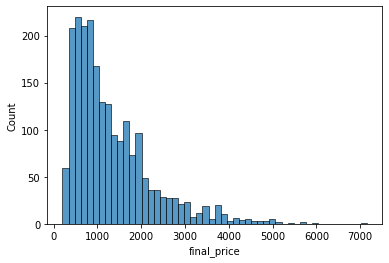

In [23]:
sns.histplot(df.final_price, bins=50)

The tail of 'final_variable' is not that long.

### Question 1
There's one column with missing values. What is it?

In [30]:
df.isnull().sum()

laptop             0
status             0
brand              0
model              0
cpu                0
ram                0
storage            0
storage_type      42
gpu             1371
screen             4
touch              0
final_price        0
dtype: int64

Answer: screen

### Question 2
What's the median (50% percentile) for variable 'ram'?

In [31]:
df.ram.median()

16.0

Answer: 16

### Prepare and split the dataset

In [32]:
# shuffle the data
n = len(df)
idx = np.arange(n)

np.random.seed(42)
np.random.shuffle(idx)

In [33]:
# slip the data in sets
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_train.head(2)

,laptop,status,brand,model,cpu,ram,storage,storage_type,gpu,screen,touch,final_price
2079,MSI Modern 15 A11SBU-620XES Intel Core i7-1165...,Refurbished,MSI,Modern,Intel Core i7,32,1000,SSD,MX 450,15.6,No,1123.29
668,Thomson Neo White Intel Celeron N4020/4GB/64GB...,New,Thomson,Neo,Intel Celeron,4,64,eMMC,NaN,14.1,No,201.05


In [34]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [35]:
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

In [36]:
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

#### Question 3
We need to deal with missing values for the column from Q1.\
We have two options: fill it with 0 or with the mean of this variable.\
Try both options. For each, train a linear regression model without regularization using the code from the lessons.\
For computing the mean, use the training only!\
Use the validation dataset to evaluate the models and compare the RMSE of each option.\
Round the RMSE scores to 2 decimal digits using round(score, 2)\
Which option gives better RMSE?

In [40]:
# columns we will use
base = ['ram', 'storage', 'screen']

In [62]:
# Functions from the lessons code

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

# prepare_X modified to choose filling option
def prepare_X(df,fill):
    df_num = df[base]
    df_num = df_num.fillna(fill)
    X = df_num.values
    return X

Using 0 to fill NaNs:

w0 = 676.8954853009992

w = [ 43.70681555   0.86506867 -36.10399833]

RMSE: 597.36


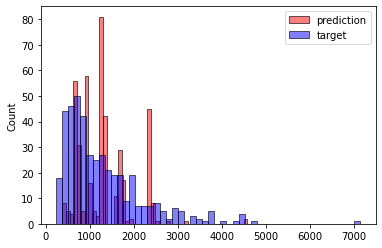

In [54]:
# Filling NaNs with 0

# Training part:
X_train = prepare_X(df_train, 0)
w0, w = train_linear_regression(X_train, y_train)

# Validation part:
X_val = prepare_X(df_val, 0)
y_pred = w0 + X_val.dot(w)

print('Using 0 to fill NaNs:')
print('')
print('w0 =', w0)
print('')
print('w =', w)
print('')
print('RMSE:', round(rmse(y_val, y_pred), 2))

sns.histplot(y_pred, label='prediction', color='red', alpha=0.5, bins=50)
sns.histplot(y_val, label='target', color='blue',  alpha=0.5, bins=50)
plt.legend()

Using mean to fill NaNs:

w0 = 808.9159907343582

w = [ 43.90774584   0.87135236 -45.18273312]

RMSE: 600.27


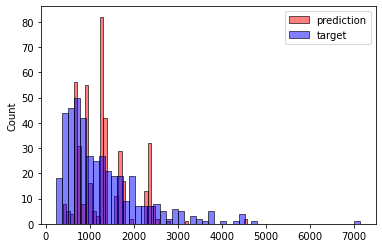

In [53]:
# Filling NaNs with mean

# Training part:
X_train = prepare_X(df_train, df_train.screen.mean())
w0, w = train_linear_regression(X_train, y_train)

# Validation part:
X_val = prepare_X(df_val, df_train.screen.mean())
y_pred = w0 + X_val.dot(w)

print('Using mean to fill NaNs:')
print('')
print('w0 =', w0)
print('')
print('w =', w)
print('')
print('RMSE:', round(rmse(y_val, y_pred), 2))

sns.histplot(y_pred, label='prediction', color='red', alpha=0.5, bins=50)
sns.histplot(y_val, label='target', color='blue',  alpha=0.5, bins=50)
plt.legend()

Answer: RMSE using 0s is a little lower, therefore it is technically better for filling the NaNs. But the difference may not be significant.

### Question 4
Now let's train a regularized linear regression.\
For this question, fill the NAs with 0.\
Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].\
Use RMSE to evaluate the model on the validation dataset.\
Round the RMSE scores to 2 decimal digits.\
Which r gives the best RMSE?

In [55]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [56]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train = prepare_X(df_train, 0)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(df_val, 0)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print(r, w0, round(score, 2))

0 676.8954853009992 597.36
0.01 676.2736817211679 597.36
0.1 670.7284836318768 597.35
1 619.9030834112974 597.21
5 463.77716971451275 597.01
10 352.7971336770062 597.06
100 66.92071440183614 597.9


Answer: 5, then 10

### Question 5
We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.\
Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].\
For each seed, do the train/validation/test split with 60%/20%/20% distribution.\
Fill the missing values with 0 and train a model without regularization.\
For each seed, evaluate the model on the validation dataset and collect the RMSE scores.\
What's the standard deviation of all the scores? To compute the standard deviation, use np.std.\
Round the result to 3 decimal digits (round(std, 3))\
What's the value of std?

In [64]:
rmse_values = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    # shuffle the data
    n = len(df)
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    # slip the data in sets
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']

    # Training part:
    X_train = prepare_X(df_train, 0)
    w0, w = train_linear_regression(X_train, y_train)

    # Validation part:
    X_val = prepare_X(df_val, 0)
    y_pred = w0 + X_val.dot(w)

    # Collect RMSEs
    rmse_values.append(rmse(y_val, y_pred))

print(rmse_values)
print('')
print('std =', round(np.std(rmse_values), 3))

[565.4520868770992, 636.7985423056716, 588.9558697907979, 597.8148920012542, 571.9627915111046, 573.2383256618959, 647.3438328407311, 550.4398184485875, 587.333503616987, 576.1017929433077]

std = 29.176


Answer: 29.176

### Question 6
Split the dataset like previously, use seed 9.\
Combine train and validation datasets.\
Fill the missing values with 0 and train a model with r=0.001.\
What's the RMSE on the test dataset?

In [65]:
# shuffle the data
n = len(df)
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

# slip the data in sets
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [68]:
# Combine train and validation datasets
df_comb = pd.concat([df_train, df_val], axis=0)
y_comb = np.concatenate([y_train, y_val])

# Training part:
X_comb = prepare_X(df_comb, 0)
w0, w = train_linear_regression_reg(X_comb, y_comb, r=0.001)

In [70]:
# Validation part:
X_test = prepare_X(df_test, 0)
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
    
print('RMSE: ', round(score, 2))

RMSE:  608.61


Answer: 608.6